In [13]:
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale, resize, iradon
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import from_scipy_sparse_matrix, to_scipy_sparse_matrix
import scipy.sparse as sp
from torch.utils.data import Dataset, DataLoader
import yaml
from tqdm import tqdm  # Import tqdm
import astra
import cv2
import os
from AstraSinogramDataLoader import *
import math
from torch_geometric.nn.conv import GCNConv
from models import TomoGNN

In [14]:
def get_image_and_sinogram(image, num_pixels):
    img_size = num_pixels
    num_detectors = num_pixels
    detector_size = 1
    num_angles = num_pixels #180
    vol_geom  = astra.create_vol_geom(img_size, img_size)
    proj_geom = astra.create_proj_geom('parallel', detector_size, num_detectors, np.linspace(0,np.pi,num_angles,False))
    proj_id   = astra.create_projector('strip', proj_geom, vol_geom)

    image = cv2.resize(image, (img_size , img_size ))

    sinogram = astra_create_sinogram(image, proj_id)
    sinogram_noisy = astra_create_sinogram_w_noise(image, proj_id, io_value=1000)
    return image, sinogram, sinogram_noisy

In [15]:
# Define hyperparameters:
num_pixels    = 256 #256
img_size      = 256 #256
num_detectors = 256 #256
detector_size = 1
num_angles    = 256

vol_geom  = astra.create_vol_geom(num_pixels, num_pixels)
proj_geom = astra.create_proj_geom('parallel', detector_size, num_detectors, np.linspace(0,np.pi,num_angles,False))
proj_id   = astra.create_projector('strip', proj_geom, vol_geom)

system_matrix_id = astra.projector.matrix(proj_id)
system_matrix    = astra.matrix.get(system_matrix_id)
adj_matrix       = sp.csr_matrix(system_matrix)
# get tensor from adj_matrix:
edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)
edge_index = torch.tensor(edge_index.clone().detach())
edge_index[1] = edge_index[1] + torch.max(edge_index[0]) + 1
edge_weight = torch.tensor(edge_weight.clone().detach())

/tmp/ipykernel_2095068/1812776409.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index.clone().detach())
/tmp/ipykernel_2095068/1812776409.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_weight = torch.tensor(edge_weight.clone().detach())


In [16]:
#dir_images = '/home/youness/data/PET_Recons/Anonym_MICCAI_Code/Images/BrainWeb/'
tdir_images= '/home/youness/data/PET_Recons/Anonym_MICCAI_Code/Images/BrainWeb/'

RecoDataset = AstraSinogramImageDataset_w_noise(dir_images, tdir_images, mode='test', num_img_train=50, num_img_test=10, vol_geom=vol_geom, proj_geom=proj_geom, proj_id=proj_id, new_shape=num_pixels)
test_dataloader = DataLoader(RecoDataset, batch_size=1, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # torch.device('cpu')

In [17]:
def Inference_on_single_image(global_model):
    # Load the model:
    state_dict = torch.load('/home/youness/data/PET_Recons/Anonym_MICCAI_Code/Weights/'+"paradigm2_weights_epoch_233.pth")
    global_model.load_state_dict(state_dict)

    # import an image and get the sinogram:
    img_number = "452"
    image = np.load("/home/youness/data/Data/TBodyPET/Images_test_Png/PET_test_slice_"+str(img_number)+".npy") #404 #300 # 500 # 561 #351
    image = cv2.resize(image.squeeze(), (img_size,img_size))
    _, sino, noisy_sino = get_image_and_sinogram(image, num_pixels)


    image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device)
    noisy_sino = torch.from_numpy(noisy_sino).unsqueeze(0).unsqueeze(0).to(device)
    
                
    my_img  = image.float() #torch.zeros_like(image) #image.float() #
    my_sino = noisy_sino.float()
    
    out = global_model(my_sino, edge_index, edge_weight)
    
    # select nodes of the image space, then normalize the output:
    my_out = out[-num_pixels*num_pixels:].reshape(num_pixels,num_pixels).cpu().detach().numpy()
    my_out = (my_out - np.min(my_out)) / (np.max(my_out) - np.min(my_out))
    # normalizing the input:
    my_img = my_img.squeeze().cpu().detach().numpy()
    my_img = (my_img - np.min(my_img)) / (np.max(my_img) - np.min(my_img))

    fig, axs = plt.subplots(1,4)
    max_cmap = torch.max(my_sino).item() #/ 0.05
    axs[0].imshow(my_sino.squeeze().cpu().detach().numpy(), cmap='gray', vmin=0, vmax=max_cmap)
    axs[0].set_title('Sinogram')

    
    axs[1].imshow(my_img, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title('Image')
    
    # normalizing the output:
    axs[2].imshow(my_out, cmap='gray', vmin=0, vmax=1)
    axs[2].set_title('Projection2ImageSpace')
    
    axs[3].imshow(my_img - my_out, cmap='seismic', vmin=-1, vmax=1)
    axs[3].set_title('Diff')
    plt.show()

def Inference(global_model, test_dataloader):
    # Load the model:
    state_dict = torch.load('/home/youness/data/PET_Recons/AstraGNNMICCAI/MyModel/Weights4test/'+"paradigm2_weights_epoch_233.pth")
    global_model.load_state_dict(state_dict)

    with torch.no_grad():
        for sinograms, images in test_dataloader:
            for batch in range(sinograms.shape[0]):
                my_sino = sinograms.float().to(device) 
                my_img  = images.float().to(device)

                
                out = global_model(my_sino, edge_index, edge_weight)
                
                # select nodes of the image space, then normalize the output:
                my_out = out[-num_pixels*num_pixels:].reshape(num_pixels,num_pixels).cpu().detach().numpy()
                my_out = (my_out - np.min(my_out)) / (np.max(my_out) - np.min(my_out))
                # normalizing the input:
                my_img = my_img.squeeze().cpu().detach().numpy()
                my_img = (my_img - np.min(my_img)) / (np.max(my_img) - np.min(my_img))

                fig, axs = plt.subplots(1,4)
                max_cmap = torch.max(my_sino).item() #/ 0.05
                axs[0].imshow(my_sino.squeeze().cpu().detach().numpy(), cmap='gray', vmin=0, vmax=max_cmap)
                axs[0].set_title('Sinogram')

                
                axs[1].imshow(my_img, cmap='gray', vmin=0, vmax=1)
                axs[1].set_title('Image')
                
                # normalizing the output:
                axs[2].imshow(my_out, cmap='gray', vmin=0, vmax=1)
                axs[2].set_title('Projection2ImageSpace')
               
                axs[3].imshow(my_img - my_out, cmap='seismic', vmin=-1, vmax=1)
                axs[3].set_title('Diff')
                plt.show()

In [18]:
def lauch_inference():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # torch.device('cpu')
    global_model = TomoGNN(num_pixels=num_pixels, num_detectors=num_detectors, num_angles=num_angles).to(device)
    Inference(global_model, test_dataloader)
    Inference_on_single_image(global_model)

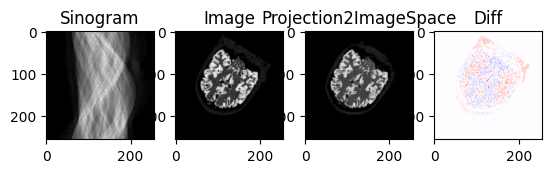

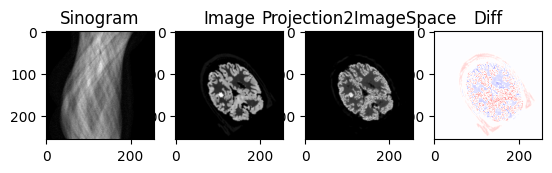

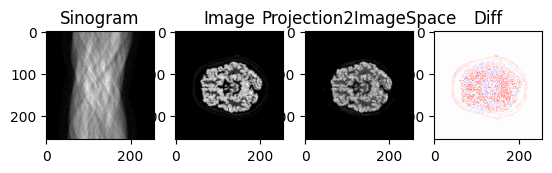

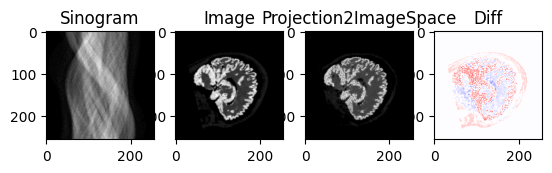

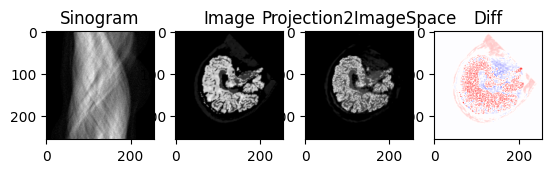

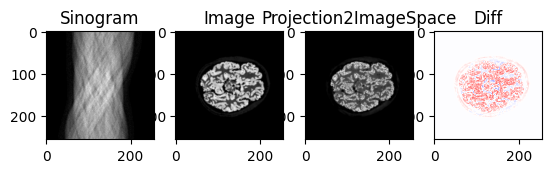

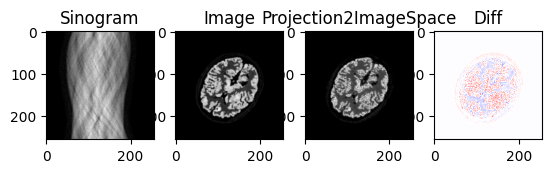

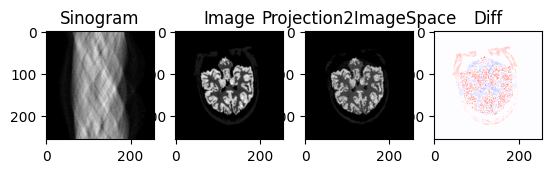

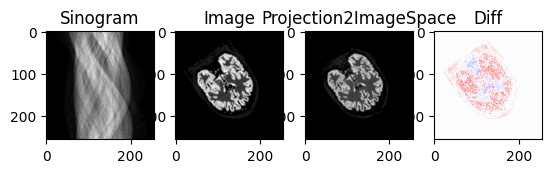

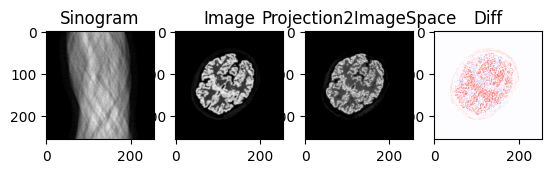

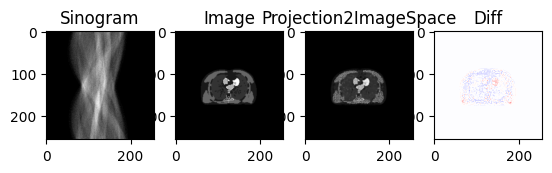

In [19]:
lauch_inference()